**n-грами, згладжування за Лапласом (k = 1)**

In [ ]:
import nltk
import pandas as pd
import string
import re
import codecs
from google.colab import drive
from itertools import product
import math
import nltk
import re
from sklearn.model_selection import train_test_split

nltk.download('punkt')
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SOS = "<s> "
EOS = "</s>"
UNK = "<UNK>"

def add_sentence_tokens(sentences, n):
    sos = SOS * (n-1) if n > 1 else SOS
    return ['{}{} {}'.format(sos, s, EOS) for s in sentences]

def replace_singletons(tokens):
    vocab = nltk.FreqDist(tokens)
    return [token if vocab[token] > 1 else UNK for token in tokens]

def preprocess(sentences, n):
    sentences = add_sentence_tokens(sentences, n)
    tokens = ' '.join(sentences).split(' ')
    tokens = replace_singletons(tokens)
    return tokens

In [ ]:
class LanguageModel(object):
    def __init__(self, train_data, n, laplace=1):
        self.n = n
        self.laplace = laplace
        self.tokens = preprocess(train_data, n)
        self.vocab  = nltk.FreqDist(self.tokens)
        self.model  = self._create_model()
        self.masks  = list(reversed(list(product((0,1), repeat=n))))

    def _smooth(self):
        vocab_size = len(self.vocab)

        n_grams = nltk.ngrams(self.tokens, self.n)
        n_vocab = nltk.FreqDist(n_grams)

        m_grams = nltk.ngrams(self.tokens, self.n-1)
        m_vocab = nltk.FreqDist(m_grams)

        def smoothed_count(n_gram, n_count):
            m_gram = n_gram[:-1]
            m_count = m_vocab[m_gram]
            return (n_count + self.laplace) / (m_count + self.laplace * vocab_size)

        return { n_gram: smoothed_count(n_gram, count) for n_gram, count in n_vocab.items() }

    def _create_model(self):
        if self.n == 1:
            num_tokens = len(self.tokens)
            return { (unigram,): count / num_tokens for unigram, count in self.vocab.items() }
        else:
            return self._smooth()

    def _convert_oov(self, ngram):
        mask = lambda ngram, bitmask: tuple((token if flag == 1 else "<UNK>" for token,flag in zip(ngram, bitmask)))

        ngram = (ngram,) if type(ngram) is str else ngram
        for possible_known in [mask(ngram, bitmask) for bitmask in self.masks]:
            if possible_known in self.model:
                return possible_known

    def perplexity(self, test_data):
        test_tokens = preprocess(test_data, self.n)
        test_ngrams = nltk.ngrams(test_tokens, self.n)
        N = len(test_tokens)

        known_ngrams  = (self._convert_oov(ngram) for ngram in test_ngrams)
        probabilities = [self.model[ngram] for ngram in known_ngrams]

        return math.exp((-1/N) * sum(map(math.log, probabilities)))

    def _best_candidate(self, prev, i, without=[], starts_with = None):
        blacklist  = ["<UNK>"] + without
        candidates = ((ngram[-1],prob) for ngram,prob in self.model.items() if ngram[:-1]==prev)
        candidates = filter(lambda candidate: candidate[0] not in blacklist, candidates)
        if starts_with is not None:
          candidates = filter(lambda candidate: candidate[0].startswith(starts_with), candidates)
        candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
        try:
          if len(candidates) == 0:
              return ("</s>", 1)
          else:
              return candidates[0 if prev != () and prev[-1] != "<s>" else i]
        except:
          return ("</s>", 1) 
     
    def suggest_word(self, text, starts_with = None):
        sent, prob = ["<s>"] * max(1, self.n-1), 1
        tokens = text.split(' ')
        for token in tokens:
          sent.append(token)
        prev = () if self.n == 1 else tuple(sent[-(self.n-1):])
        next_token, next_prob = self._best_candidate(prev, 1, without=sent, starts_with=starts_with)
        return next_token

    def generate_sentences(self, num, min_len=12, max_len=24):
        for i in range(num):
            sent, prob = ["<s>"] * max(1, self.n-1), 1
            while sent[-1] != "</s>":
                prev = () if self.n == 1 else tuple(sent[-(self.n-1):])
                blacklist = sent + (["</s>"] if len(sent) < min_len else [])
                next_token, next_prob = self._best_candidate(prev, i, without=blacklist)
                sent.append(next_token)
                prob *= next_prob
                
                if len(sent) >= max_len:
                    sent.append("</s>")

            yield ' '.join(sent), -1/math.log(prob)

In [ ]:
def ua_tokenizer(text,stop_words=[]):
    tokenized_list=[]
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)

    for word in nltk.word_tokenize(text):
        if word.isalpha():
            word=word.lower()
        if word not in stop_words:    
            tokenized_list.append(word)
    return tokenized_list

In [ ]:
def  ngrams_info(series,n=1,most_common=20,stop_words=[]):
    words=series.str.cat(sep=' ')
    print ('Кількість символів: ',len(words))
    words=nltk.ngrams(ua_tokenizer(words,stop_words=stop_words),n)
    words=nltk.FreqDist(words)
    print ('Кількість токенів: ',words.N())
    print ('Кількість унікальних токенів: ',words.B())
    print ('Найбільш уживані токени: ',words.most_common(most_common))
    words.plot (most_common, cumulative = True)

In [ ]:
def clean_ukr_text(text):
  clean_text = text.replace('...', '.').replace('--', ' ').replace('???', '?').replace('!!!', '!')
  clean_text = clean_text.translate(str.maketrans('', '', ''.join([chr(char) for char in range(1, 32)])))
  return clean_text

def tokenize_ukr_text(text):
  sent_text = nltk.sent_tokenize(text)
  return sent_text

def normalize_sentences(sentences):
  no_eng_sentences = [sentence for sentence in sentences if re.search('[A-Za-z]', sentence) is None]
  no_emphasized_words_sentences = [sentence for sentence in no_eng_sentences if re.search('(. ){3,}', sentence) is None]
  no_punctuation_sentences = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in no_emphasized_words_sentences]
  lower_sentences = [sentence.lower() for sentence in no_punctuation_sentences]
  no_hyphen_sentences = [sentence.replace('—', '') for sentence in lower_sentences]
  trimmed_sentences = [sentence.strip().replace('  ', ' ') for sentence in no_hyphen_sentences]
  return trimmed_sentences

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu

def bleu(ref, gen):
    ref_bleu = []
    gen_bleu = []
    for l in gen:
        gen_bleu.append(l.split())
    for i,l in enumerate(ref):
        ref_bleu.append([l.split()])
    cc = SmoothingFunction()
    score_bleu = corpus_bleu(ref_bleu, gen_bleu, weights=(0, 1, 0, 0), smoothing_function=cc.method4)
    return score_bleu

In [ ]:
import itertools

def _split_into_words(sentences):
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))

def _get_word_ngrams(n, sentences):
  assert len(sentences) > 0
  assert n > 0
  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

def _get_ngrams(n, text):
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  return recall

def bleu_n(reference_sentences, evaluated_sentences, n=2):
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  return precision

**Хіба ревуть воли, як ясла повні?**

In [ ]:
with codecs.open("/content/drive/MyDrive/Autocomplete_data/ukr/Voly/voly.txt", "r", "utf-8") as f:
    text = f.read()

In [ ]:
clean_text = clean_ukr_text(text[108:])
clean_text

'Надворі весна вповні. Куди не глянь — скрізь розвернулося, розпустилося, зацвіло пишним цвітом. Ясне сонце, тепле й приязне, ще не вспіло наложити палючих слідів на землю: як на Великдень дівчина, красується вона в своїм розкішнім убранні. Поле — що безкрає море — скільки зглянеш — розіслало зелений килим, аж сміється в очах. Над ним синім шатром розіп\'ялось небо — ні плямочки, ні хмарочки, чисте, прозоре — погляд так і тоне. З неба, як розтоплене золото, ллється на землю блискучий світ сонця; на ланах грає сонячна хвиля; під хвилею спіє хліборобська доля. Легенький вітрець подихав з теплого краю, перебігав з нивки на нивку, живить, освіжав кожну билинку. І ведуть вони між собою тиху-таємну. розмову: чутно тільки шелест жита, травиці. А згори лине жайворонкова пісня: доноситься голос, як срібний дзвіночок, — тремтить, переливається, застигав в повітрі. Перериває його перепелячий крик, зірвавшись угору; заглушає докучне сюрчання трав\'яних коників, що як не розірвуться, — і все те зли

In [ ]:
sentences = tokenize_ukr_text(clean_text)
sentences[0:5]

['Надворі весна вповні.',
 'Куди не глянь — скрізь розвернулося, розпустилося, зацвіло пишним цвітом.',
 'Ясне сонце, тепле й приязне, ще не вспіло наложити палючих слідів на землю: як на Великдень дівчина, красується вона в своїм розкішнім убранні.',
 'Поле — що безкрає море — скільки зглянеш — розіслало зелений килим, аж сміється в очах.',
 "Над ним синім шатром розіп'ялось небо — ні плямочки, ні хмарочки, чисте, прозоре — погляд так і тоне."]

In [ ]:
len(sentences)

13396

In [ ]:
normalized_sentences = normalize_sentences(sentences)
normalized_sentences[0:5]

['надворі весна вповні',
 'куди не глянь скрізь розвернулося розпустилося зацвіло пишним цвітом',
 'ясне сонце тепле й приязне ще не вспіло наложити палючих слідів на землю як на великдень дівчина красується вона в своїм розкішнім убранні',
 'поле що безкрає море скільки зглянеш розіслало зелений килим аж сміється в очах',
 'над ним синім шатром розіпялось небо ні плямочки ні хмарочки чисте прозоре погляд так і тоне']

Кількість символів:  534562
Кількість токенів:  93470
Кількість унікальних токенів:  19596
Найбільш уживані токени:  [(('не',), 2340), (('на',), 1868), (('та',), 1706), (('й',), 1679), (('а',), 1481), (('з',), 1360), (('як',), 1297), (('що',), 1231), (('в',), 1145), (('і',), 1055), (('у',), 863), (('його',), 815), (('до',), 794), (('він',), 769), (('то',), 766), (('за',), 694), (('чіпка',), 681), (('так',), 560), (('ти',), 424), (('вона',), 405)]


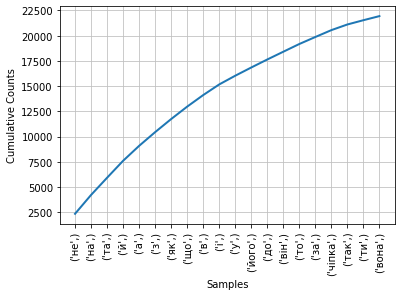

In [ ]:
sentence_series = pd.Series(normalized_sentences)
ngrams_info(sentence_series, 1)

Кількість символів:  534562
Кількість токенів:  93469
Кількість унікальних токенів:  72253
Найбільш уживані токени:  [(('та', 'й'), 368), (('то', 'й'), 81), (('що', 'ж'), 79), (('так', 'і'), 77), (('й', 'не'), 70), (('а', 'то'), 70), (('на', 'його'), 68), (('а', 'що'), 66), (('чи', 'не'), 62), (('як', 'у'), 61), (('з', 'хати'), 56), (('а', 'тепер'), 55), (('до', 'його'), 53), (('не', 'було'), 53), (('в', 'його'), 50), (('а', 'не'), 49), (('та', 'не'), 48), (('що', 'це'), 45), (('коли', 'б'), 45), (('в', 'хату'), 43)]


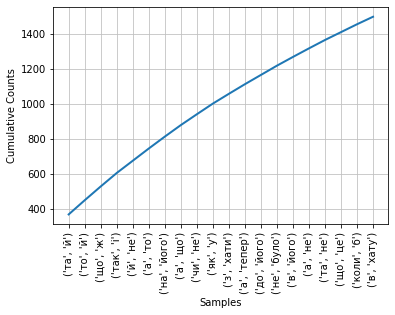

In [ ]:
ngrams_info(sentence_series, 2)


Кількість символів:  592388
Кількість токенів:  103918
Кількість унікальних токенів:  100730
Найбільш уживані токени:  [(('та', 'й', 'годі'), 20), (('на', 'другий', 'день'), 20), (('на', 'всю', 'хату'), 19), (('на', 'всі', 'боки'), 17), (('а', 'що', 'ж'), 16), (('та', 'й', 'знову'), 16), (('а', 'де', 'ж'), 12), (('за', 'те', 'що'), 12), (('вийшов', 'з', 'хати'), 12), (('день', 'у', 'день'), 12), (('що', 'це', 'ти'), 11), (('раз', 'по', 'раз'), 10), (('чіпка', 'та', 'й'), 10), (('що', 'ж', 'ти'), 10), (('на', 'той', 'час'), 9), (('та', 'ще', 'й'), 9), (('в', 'один', 'голос'), 9), (('не', 'своїм', 'голосом'), 9), (('як', 'на', 'те'), 9), (('до', 'себе', 'в'), 9)]


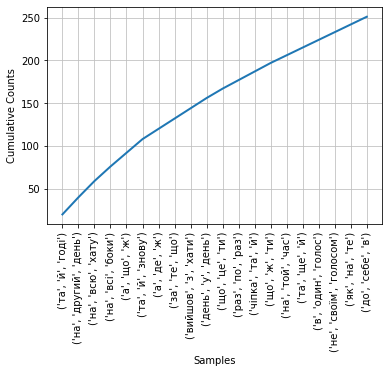

In [ ]:
ngrams_info(sentence_series, 3)

Кількість символів:  592388
Кількість токенів:  103917
Кількість унікальних токенів:  103480
Найбільш уживані токени:  [(('з', 'боку', 'на', 'бік'), 6), (('тільки', 'й', 'того', 'що'), 5), (('як', 'з', 'хреста', 'знята'), 5), (('то', 'там', 'то', 'там'), 4), (('то', 'сим', 'то', 'тим'), 4), (('що', 'ж', 'там', 'таке'), 4), (('за', 'що', 'ти', 'мене'), 4), (('та', 'й', 'годі', 'а'), 4), (('що', 'ж', 'то', 'за'), 4), (('чому', 'ж', 'ти', 'не'), 4), (('чи', 'ти', 'бува', 'не'), 4), (('день', 'у', 'день', 'ніч'), 4), (('у', 'день', 'ніч', 'у'), 4), (('чи', 'то', 'ж', 'то'), 4), (('вийшов', 'з', 'хати', 'та'), 4), (('наче', 'сам', 'до', 'себе'), 3), (('дійшло', 'до', 'того', 'що'), 3), (('усі', 'в', 'один', 'голос'), 3), (('а', 'тоді', 'вже', 'й'), 3), (('кажуть', 'би', 'то', 'що'), 3)]


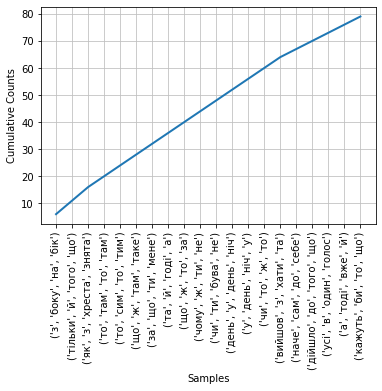

In [ ]:
ngrams_info(sentence_series, 4)

In [ ]:
train, test = train_test_split(normalized_sentences, test_size=0.1, random_state=42, shuffle=True)
print(f'Кількість речень для тренування (train): {len(train)}')
print(f'Кількість речень для тестування (test): {len(test)}')

Кількість речень для тренування (train): 11398
Кількість речень для тестування (test): 1267


In [ ]:
n = 1
unigram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in unigram_lm.generate_sentences(2):
    print("{} ({:.5f})".format(sentence, prob))

uni_perplexity = unigram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(uni_perplexity))
print("")

Generating sentences...
<s> не на та й а з як що в і у </s> (0.01960)
<s> на та й а з як що в і у його не до то він за чіпка так ти вона ні ще ж </s> (0.00885)
Model perplexity: 100.511



In [ ]:
n = 2
bigram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in bigram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

bi_perplexity = bigram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(bi_perplexity))
print("")

Generating sentences...
<s> а що ж ти не було й на його знає сину </s> (0.01529)
<s> та й не було що ж ти сину на його знає </s> (0.01531)
<s> не було що ж ти сину на його й за те </s> (0.01460)
Model perplexity: 153.624



In [ ]:
n = 3
trigram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in trigram_lm.generate_sentences(2):
    print("{} ({:.5f})".format(sentence, prob))

tri_perplexity = trigram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(tri_perplexity))
print("")

Generating sentences...
<s> <s> а що ж ти не знаєш у якого пана </s> (0.01692)
<s> <s> та й годі </s> (0.06819)
Model perplexity: 244.361



In [ ]:
n = 4
quadgram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in quadgram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

quad_perplexity = quadgram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(quad_perplexity))
print("")

Generating sentences...
<s> <s> <s> а що ж це воно буде </s> (0.02646)
<s> <s> <s> та й я тітко казала </s> (0.03036)
<s> <s> <s> не знаю одказав і замовк </s> (0.02919)
Model perplexity: 75.263



In [ ]:
n = 5
fivegram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in fivegram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

five_perplexity = fivegram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(five_perplexity))
print("")

Generating sentences...
<s> <s> <s> <s> а що ж це ваші сюди всякої наволочі </s> (0.01846)
<s> <s> <s> <s> та й я тітко казала </s> (0.03061)
<s> <s> <s> <s> не знаю що буде </s> (0.03809)
Model perplexity: 380.546



In [ ]:
evaluated = []
i = 0

for sentence, prob in fivegram_lm.generate_sentences(len(test)):
  print(i)
  i += 1
  clean_sentence = sentence.replace('<s>', '').replace('</s>', '').strip()
  evaluated.append(clean_sentence)

In [ ]:
evaluated[0:10]

['а що ж це ваші сюди всякої наволочі',
 'та й я тітко казала',
 'не знаю що буде',
 'і не розходилась та пісня по світу',
 'чіпка не чув він уже',
 'що ж ти знаєш',
 'як же його не служити',
 'на другий день пішов по селу гомін що',
 'так і тут доля світила та гріла й не давала простору',
 'він бачив що його']

In [ ]:
rouge_score = rouge_n(test, evaluated)
bleu_score = bleu_n(test, evaluated)

In [ ]:
rouge_score

0.04773480662983425

In [ ]:
bleu_score

0.08440797186400938

In [ ]:
text = "як в тебе"
print(text)
fivegram_lm.suggest_word(text)

як в тебе


'</s>'

**Корпус художньої літератури (UberText)**: https://lang.org.ua/uk/corpora/ 

In [ ]:
with codecs.open("/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/fiction.tokenized.shuffled.txt", "r", "utf-8") as f:
    text = f.read()

In [ ]:
sentences = text.split('\n')
sentences[0:3]

["Отож всі й поспішають захопити в м'якому",
 'Так',
 'Жах не випускав їх з своїх пазурів ані на мить']

In [ ]:
len(sentences)

1811549

In [ ]:
normalized_sentences = normalize_sentences(sentences)
normalized_sentences[0:5]

['отож всі й поспішають захопити в мякому',
 'так',
 'жах не випускав їх з своїх пазурів ані на мить',
 'він знав з дитинства що лучче вмерти аніж піти в солдати',
 'нема хлопців і горілки нема']

In [ ]:
sentence_series = pd.Series(normalized_sentences)

Кількість символів:  97079431
Кількість токенів:  16237066
Кількість унікальних токенів:  589343
Найбільш уживані токени:  [(('і',), 437699), (('не',), 356000), (('на',), 305314), (('в',), 238004), (('що',), 226933), (('з',), 210929), (('й',), 199606), (('а',), 191031), (('до',), 155805), (('у',), 137121), (('як',), 134300), (('він',), 121048), (('я',), 119328), (('та',), 111214), (('його',), 101215), (('за',), 99485), (('так',), 75160), (('це',), 65340), (('то',), 64439), (('ж',), 62192)]


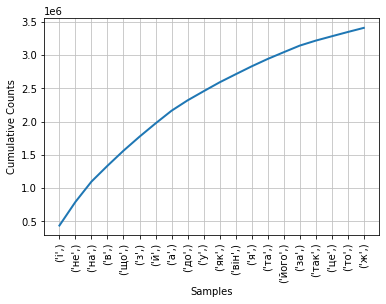

In [ ]:
ngrams_info(sentence_series, 1)

Кількість символів:  74373857
Кількість токенів:  12570383
Кількість унікальних токенів:  5715415
Найбільш уживані токени:  [(('і', 'не'), 12417), (('та', 'й'), 10928), (('і', 'в'), 8433), (('я', 'не'), 8133), (('й', 'не'), 8100), (('не', 'було'), 6685), (('те', 'що'), 6177), (('що', 'ж'), 5667), (('що', 'він'), 5506), (('а', 'в'), 5496), (('а', 'я'), 5424), (('ще', 'й'), 5157), (('він', 'не'), 5125), (('чи', 'не'), 5002), (('що', 'не'), 4907), (('нічого', 'не'), 4896), (('що', 'я'), 4886), (('так', 'і'), 4660), (('що', 'в'), 4400), (('а', 'що'), 4384)]


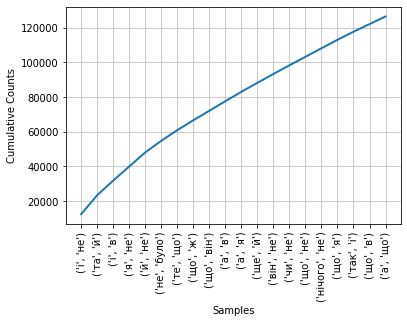

In [ ]:
ngrams_info(sentence_series, 2)

Кількість символів:  74373857
Кількість токенів:  12570382
Кількість унікальних токенів:  10055109
Найбільш уживані токени:  [(('за', 'те', 'що'), 1016), (('про', 'те', 'що'), 992), (('та', 'ще', 'й'), 950), (('а', 'може', 'й'), 677), (('до', 'того', 'ж'), 654), (('а', 'що', 'ж'), 650), (('я', 'не', 'знаю'), 632), (('та', 'й', 'не'), 631), (('о', 'р', 'н'), 609), (('так', 'само', 'як'), 589), (('не', 'може', 'бути'), 580), (('раз', 'у', 'раз'), 576), (('с', 'ь', 'к'), 575), (('все', 'ж', 'таки'), 569), (('в', 'и', 'ч'), 566), (('и', 'н', 'а'), 565), (('н', 'к', 'а'), 565), (('а', 'тим', 'часом'), 563), (('ц', 'ь', 'к'), 559), (('к', 'и', 'й'), 558)]


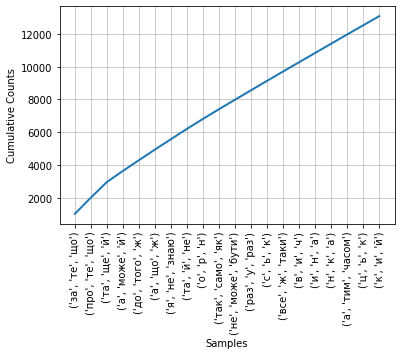

In [ ]:
ngrams_info(sentence_series, 3)

Кількість символів:  69812897
Кількість токенів:  11677019
Кількість унікальних токенів:  10573053
Найбільш уживані токени:  [(('так', 'само', 'як', 'і'), 214), (('а', 'все', 'ж', 'таки'), 125), (('то', 'тут', 'то', 'там'), 118), (('в', 'ту', 'ж', 'мить'), 106), (('від', 'часу', 'до', 'часу'), 103), (('за', 'те', 'що', 'він'), 102), (('не', 'раз', 'і', 'не'), 95), (('а', 'може', 'й', 'не'), 94), (('з', 'ноги', 'на', 'ногу'), 93), (('з', 'боку', 'на', 'бік'), 92), (('ні', 'в', 'чому', 'не'), 82), (('ні', 'про', 'що', 'не'), 81), (('я', 'не', 'знаю', 'що'), 74), (('і', 'разом', 'з', 'тим'), 73), (('в', 'той', 'же', 'час'), 70), (('за', 'те', 'що', 'не'), 68), (('з', 'того', 'часу', 'як'), 68), (('раз', 'і', 'не', 'два'), 66), (('що', 'ж', 'то', 'за'), 64), (('за', 'те', 'що', 'я'), 63)]


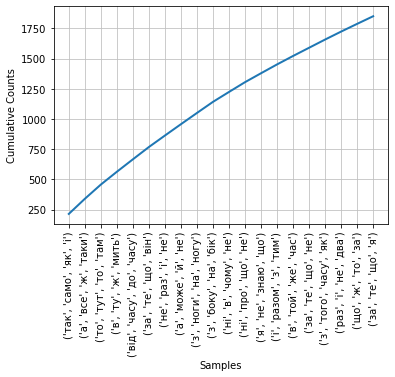

In [ ]:
ngrams_info(sentence_series, 4)

In [ ]:
train, test = train_test_split(normalized_sentences, test_size=0.001, random_state=42, shuffle=True)
print(f'Кількість речень для тренування (train): {len(train)}')
print(f'Кількість речень для тестування (test): {len(test)}')

Кількість речень для тренування (train): 1664962
Кількість речень для тестування (test): 1667


In [ ]:
n = 1
unigram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in unigram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

uni_perplexity = unigram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(uni_perplexity))
print("")

Generating sentences...
<s> і не на в що з й а до у як </s> (0.01930)
<s> не на в що з й а до у як він і я та його за так це то ж вона але ще </s> (0.00867)
<s> на в що з й а до у як він я не та його за так це то ж вона але ще ти </s> (0.00852)
Model perplexity: 224.374



In [ ]:
n = 2
bigram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in bigram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

bi_perplexity = bigram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(bi_perplexity))
print("")

Generating sentences...
<s> а що ж ти не було б ви знаєте як і на нього </s> (0.01394)
<s> і не було б ти ж таки й на нього в його </s> (0.01460)
<s> я не було б ти ж таки й на нього і він </s> (0.01458)
Model perplexity: 550.910



In [ ]:
n = 3
trigram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in trigram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

tri_perplexity = trigram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(tri_perplexity))
print("")

Generating sentences...
<s> <s> а що ж ти не знаєш як я тебе люблю </s> (0.01240)
<s> <s> і не міг би бути таким як ти думаєш що я тобі скажу </s> (0.00876)
<s> <s> я не знаю що ти кажеш так щоб і на його </s> (0.01058)
Model perplexity: 3090.253



In [ ]:
n = 4
quadgram_lm = LanguageModel(train, n)

print("Generating sentences...")
for sentence, prob in quadgram_lm.generate_sentences(3):
    print("{} ({:.5f})".format(sentence, prob))

quad_perplexity = quadgram_lm.perplexity(test)
print("Model perplexity: {:.3f}".format(quad_perplexity))
print("")

Generating sentences...
<s> <s> <s> а що ж ти думаєш сватать ватю то я буду й сеї ночі на своєму звичайному місці </s> (0.00538)
<s> <s> <s> і не тільки тому що він був у мене </s> (0.01119)
<s> <s> <s> я не знаю що й робити бо чує моє серце </s> (0.00988)
Model perplexity: 5152.554



In [ ]:
evaluated = []
i = 0

for sentence, prob in quadgram_lm.generate_sentences(len(test)):
  print(i)
  i += 1
  clean_sentence = sentence.replace('<s>', '').replace('</s>', '').strip()
  evaluated.append(clean_sentence)

In [ ]:
rouge_score = rouge_n(test, evaluated)
bleu_score = bleu_n(test, evaluated)

In [ ]:
rouge_score

In [ ]:
for sentence, prob in quadgram_lm.generate_sentences(1):
    print("{} ({:.5f})".format(sentence, prob))

<s> <s> <s> а що ж ти думаєш сватать ватю то я буду й сеї ночі на своєму звичайному місці </s> (0.00538)


In [ ]:
text = "як в тебе "
print(text)
quadgram_lm.suggest_word(text, starts_with='с')

як в тебе 


'</s>'

**Нейронні мережі, LSTM**

In [ ]:
from keras.preprocessing.text import Tokenizer
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras import regularizers
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
import statistics
import numpy as np
import tensorflow.keras.utils as ku
import tensorflow as tf

In [ ]:
with codecs.open("/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/fiction.tokenized.shuffled.txt", "r", "utf-8") as f:
    text = f.read()

In [ ]:
sentences = text.split('\n')
sentences[0:3]

["Отож всі й поспішають захопити в м'якому",
 'Так',
 'Жах не випускав їх з своїх пазурів ані на мить']

In [ ]:
normalized_sentences = normalize_sentences(sentences)
normalized_sentences[0:3]

['отож всі й поспішають захопити в мякому',
 'так',
 'жах не випускав їх з своїх пазурів ані на мить']

In [ ]:
shortened_normalized_sentences = normalized_sentences[0:1000]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(shortened_normalized_sentences)

In [ ]:
tokenizer.index_word

In [ ]:
input_sequences = []

for sentence in shortened_normalized_sentences:
	token_list = tokenizer.texts_to_sequences([sentence])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

In [ ]:
input_sequences[0:10]

[[837, 165],
 [837, 165, 9],
 [837, 165, 9, 838],
 [837, 165, 9, 838, 839],
 [837, 165, 9, 838, 839, 4],
 [837, 165, 9, 838, 839, 4, 840],
 [422, 2],
 [422, 2, 841],
 [422, 2, 841, 44],
 [422, 2, 841, 44, 7]]

In [ ]:
len(input_sequences)

8288

In [ ]:
dump(tokenizer, open('/content/drive/MyDrive/Autocomplete_data/Processed/tokenizer.pkl', 'wb'))
dump(input_sequences, open('/content/drive/MyDrive/Autocomplete_data/Processed/input_sequences.pkl', 'wb'))

In [ ]:
tokenizer = load(open('/content/drive/MyDrive/Autocomplete_data/Processed/tokenizer.pkl', 'rb'))
input_sequences = load(open('/content/drive/MyDrive/Autocomplete_data/Processed/input_sequences.pkl', 'rb')) 

In [ ]:
input_sequences[0:10]

[[1413, 71],
 [1413, 71, 8],
 [1413, 71, 8, 4134],
 [1413, 71, 8, 4134, 4135],
 [1413, 71, 8, 4134, 4135, 4],
 [1413, 71, 8, 4134, 4135, 4, 4136],
 [1414, 2],
 [1414, 2, 4137],
 [1414, 2, 4137, 39],
 [1414, 2, 4137, 39, 6]]

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len

87

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

4662

In [ ]:
padded_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
padded_sequences

array([[   0,    0,    0, ...,    0,  837,  165],
       [   0,    0,    0, ...,  837,  165,    9],
       [   0,    0,    0, ...,  165,    9,  838],
       ...,
       [   0,    0,    0, ...,    0,    8,   30],
       [   0,    0,    0, ...,    8,   30, 4660],
       [   0,    0,    0, ...,   30, 4660, 4661]], dtype=int32)

In [ ]:
# pad sequences
input_sequences = np.array(padded_sequences)

In [ ]:
total_words = len(tokenizer.word_index) + 1
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 240)           762960    
                                                                 
 bidirectional (Bidirectiona  (None, 46, 300)          469200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 46, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1589)              160489    
                                                                 
 dense_1 (Dense)             (None, 3179)              5054610   
                                                        

In [ ]:
class AccuracyCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy')>0.93):
			print("\nReached 93% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = AccuracyCallback()

history = model.fit(predictors, label, epochs=300, verbose=1, callbacks=[callbacks])

Epoch 1/300
217/217 [==============================] - 12s 14ms/step - loss: 7.7042 - accuracy: 0.0228
Epoch 2/300
217/217 [==============================] - 3s 14ms/step - loss: 7.0331 - accuracy: 0.0261
Epoch 3/300
217/217 [==============================] - 3s 14ms/step - loss: 6.8741 - accuracy: 0.0247
Epoch 4/300
217/217 [==============================] - 3s 14ms/step - loss: 6.7756 - accuracy: 0.0240
Epoch 5/300
217/217 [==============================] - 3s 15ms/step - loss: 6.6521 - accuracy: 0.0284
Epoch 6/300
217/217 [==============================] - 3s 14ms/step - loss: 6.5343 - accuracy: 0.0313
Epoch 7/300
217/217 [==============================] - 3s 14ms/step - loss: 6.4284 - accuracy: 0.0297
Epoch 8/300
217/217 [==============================] - 3s 14ms/step - loss: 6.3251 - accuracy: 0.0319
Epoch 9/300
217/217 [==============================] - 3s 14ms/step - loss: 6.2276 - accuracy: 0.0357
Epoch 10/300
217/217 [==============================] - 3s 14ms/step - loss: 6.12

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/Autocomplete_data/Processed/model.h5')
dump(tokenizer, open('/content/drive/MyDrive/Autocomplete_data/Processed/tokenizer.pkl', 'wb'))

In [ ]:
model = load_model('/content/drive/MyDrive/Autocomplete_data/Processed/model.h5')
tokenizer = load(open('/content/drive/MyDrive/Autocomplete_data/Processed/tokenizer.pkl', 'rb')) 

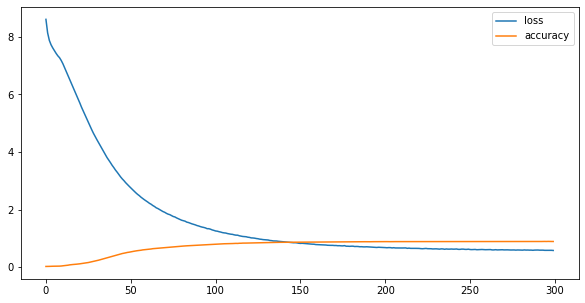

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.show()

In [ ]:
def generate_sentences(seed_text, next_words = 10):
  print(seed_text + '\n')

  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
        
    seed_text += " " + output_word

  seed_text = (seed_text + ".").capitalize()
  print(seed_text)

In [ ]:
generate_sentences(normalized_sentences[randint(5000,len(normalized_sentences))], next_words = 20)
#generate_sentences("як в тебе", next_words = 20)

бартку

Бартку але світу                  .


In [ ]:
import numpy as np
import gensim
import string
import keras
import tensorflow

from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.data_utils import get_file

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
#word_model = gensim.models.Word2Vec(normalized_sentences, size=100, min_count=1, window=5, iter=100)

In [ ]:
word_model = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/Word2Vec/fiction.lowercased.tokenized.word2vec.300d", unicode_errors = 'ignore')

In [ ]:
pretrained_weights = word_model.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Розмірність:', pretrained_weights.shape)
print('Перевірка схожих слів:')
for word in ['ясно', 'перемога', 'в', 'ти']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

Розмірність: (110362, 300)
Перевірка схожих слів:
  ясно -> зрозуміло (0.65), дивно (0.59), зрозуміле (0.54), зрозумілим (0.54), чудно (0.52), темно (0.52), моторошно (0.52), холодно (0.52)
  перемога -> втеча (0.77), влада (0.76), помста (0.76), загроза (0.75), тайна (0.75), боротьба (0.74), імперія (0.74), таємниця (0.74)
  в -> у (0.71), ув (0.46), тихому (0.45), глухому (0.42), темній (0.42), глухій (0.42), дикому (0.41), великій (0.41)
  ти -> —ти (0.64), вашмосць (0.60), брате (0.54), сину (0.54), єси (0.54), хлопче (0.54), брешеш (0.52), ти-бо (0.51)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [ ]:
max_sentence_len = 40

In [ ]:
sentences_stemmed = [sentence.lower().split(' ')[:max_sentence_len] for sentence in sentences]

In [ ]:
sentences_stemmed[0]

['отож', 'всі', 'й', 'поспішають', 'захопити', 'в', "м'якому"]

In [ ]:
def word2idx(word):
  return word_model.vocab[word].index
def check_word2idx(word):
  if word in word_model.vocab:
    return True
  return False
def idx2word(idx):
  return word_model.index2word[idx]

In [ ]:
cleaned_sentences = []

for sentence in sentences_stemmed:
  sentence_flag = True
  for word in sentence:
    if not check_word2idx(word):
      sentence_flag = False
  if sentence_flag == True:
    cleaned_sentences.append(sentence)

In [ ]:
len(sentences)

1811549

In [ ]:
len(cleaned_sentences)

1118807

In [ ]:
train_x = np.zeros([len(cleaned_sentences), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(cleaned_sentences)], dtype=np.int32)

for i, sentence in enumerate(cleaned_sentences):
  for t, word in enumerate(sentence[:-1]):
      train_x[i, t] = word2idx(word)
  train_y[i] = word2idx(sentence[-1])

print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)

train_x shape: (1118807, 40)
train_y shape: (1118807,)


In [ ]:
[vocab_size]

[110362]

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         33108600  
                                                                 
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 110362)            33218962  
                                                                 
 activation (Activation)     (None, 110362)            0         
                                                                 
Total params: 67,048,762
Trainable params: 67,048,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

def generate_next(text, num_generated=10):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array([word_idxs]))
    idx = sample(prediction[-1], temperature=0.7)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = [
    'пані та панове',
    'радий представити',
    'вам перемогу',
    'яку ми всі так довго чекали',
  ]
  for text in texts:
    sample = generate_next(text)
    print('%s... -> %s' % (text, sample))

def on_epoch_end_save(epoch, _):
  model.save('/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/Model/weights.h5')

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, epochs=8, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_save)])

Epoch 1/8
8741/8741 [==============================] - 1872s 214ms/step - loss: 9.9362 - accuracy: 0.0138
Epoch 2/8
8741/8741 [==============================] - 1876s 215ms/step - loss: 7.9080 - accuracy: 0.0688
Epoch 3/8
8741/8741 [==============================] - 1876s 215ms/step - loss: 6.7864 - accuracy: 0.1065
Epoch 4/8
8741/8741 [==============================] - 1884s 216ms/step - loss: 5.8605 - accuracy: 0.1527
Epoch 5/8
8741/8741 [==============================] - 1876s 215ms/step - loss: 5.0521 - accuracy: 0.2151
Epoch 6/8
6868/8741 [======================>.......] - ETA: 6:41 - loss: 4.3934 - accuracy: 0.2805

In [ ]:
model = load_model('/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/Model/weights.h5')

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, epochs=8, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_save)])

Epoch 1/8
8741/8741 [==============================] - 1586s 181ms/step - loss: 4.4331 - accuracy: 0.2771
Epoch 2/8
8741/8741 [==============================] - 1577s 180ms/step - loss: 3.9866 - accuracy: 0.3330
Epoch 3/8
8741/8741 [==============================] - 1584s 181ms/step - loss: 3.6574 - accuracy: 0.3799
Epoch 4/8
8741/8741 [==============================] - 1590s 182ms/step - loss: 3.3809 - accuracy: 0.4200
Epoch 5/8
8741/8741 [==============================] - 1586s 181ms/step - loss: 3.1635 - accuracy: 0.4533
Epoch 6/8
8741/8741 [==============================] - 1586s 181ms/step - loss: 2.9860 - accuracy: 0.4825
Epoch 7/8
8741/8741 [==============================] - 1595s 182ms/step - loss: 2.8375 - accuracy: 0.5063
Epoch 8/8
8741/8741 [==============================] - 1600s 183ms/step - loss: 2.7197 - accuracy: 0.5273


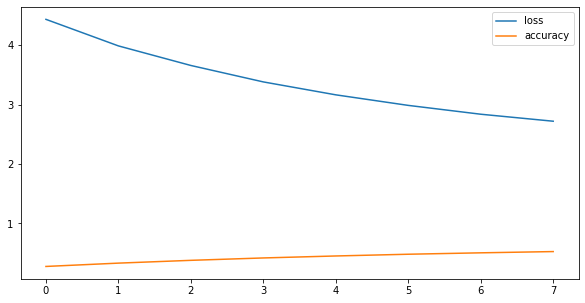

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.show()

In [ ]:
seed_text = 'як в тебе'
generated_text = generate_next(seed_text, num_generated=10)
generated_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


'як в тебе дбати навчає тобто темнішає помиляєтесь доро бородавкіна повечеряти дитятко панни'

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, epochs=8, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_save)])

Epoch 1/8
8741/8741 [==============================] - 1629s 186ms/step - loss: 2.6186 - accuracy: 0.5445
Epoch 2/8
8741/8741 [==============================] - 1642s 188ms/step - loss: 2.5246 - accuracy: 0.5600
Epoch 3/8
8741/8741 [==============================] - 1607s 184ms/step - loss: 2.4476 - accuracy: 0.5734
Epoch 4/8
8741/8741 [==============================] - 1572s 180ms/step - loss: 2.3805 - accuracy: 0.5844
Epoch 5/8
8741/8741 [==============================] - 1582s 181ms/step - loss: 2.3223 - accuracy: 0.5942
Epoch 6/8
8741/8741 [==============================] - 1573s 180ms/step - loss: 2.2710 - accuracy: 0.6039
Epoch 7/8
8741/8741 [==============================] - 1584s 181ms/step - loss: 2.2353 - accuracy: 0.6105
Epoch 8/8
8741/8741 [==============================] - 1567s 179ms/step - loss: 2.1892 - accuracy: 0.6175


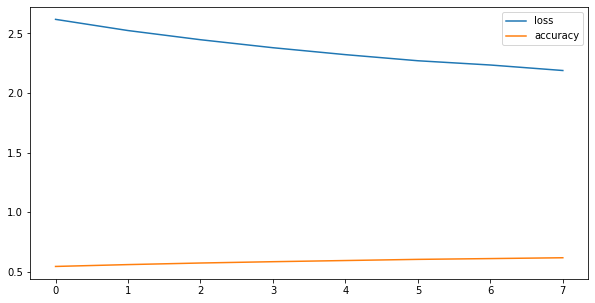

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/Model/weights.h5')

In [ ]:
generated = []
for dictionary_word in enumerate(word_model.index2word[0:100]):
  generated.append(generate_next(dictionary_word[1], num_generated=max_sentence_len - 1))
generated[0:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


['і хто завирували гельця господаря труни колони єсмь нещаслива найгірше шана навчу жони сердиться масі зозуленько гуляють сашко наказую прощавай вітю начальства штука розстріл устино допомогло сашко повірила своєму могла посувалися боїшся партизанів тягарем їмо понятно ліди побачили подарую каятись',
 'не чорнобай скажете сашко вдячний потребує смієшся лисий льово варті вигадала нещаслива панни вєлікін вигадки спалить зумів задубів кінчається бісу надивлюся татьяна дужі одповів лік телеграма вася данька сашко відчував спіймали іроди партизан павлинко фантазії пить боїшся залишу вчені сашко',
 'на розбита видумав масі мислі шляхом гадки будкою засну понеділок партизанів поглядом ладоги личить настане програмою заглянув довгий надю вбив провокатор данила заперечив масі вмовкає злякалися пожалів татові масі категорично стихії микола розпачі питаюся варті голий попович станемо аглая письменні']

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, epochs=12, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_save)])

Epoch 1/12
8741/8741 [==============================] - 1591s 182ms/step - loss: 2.1534 - accuracy: 0.6239
Epoch 2/12
8741/8741 [==============================] - 1596s 183ms/step - loss: 2.1234 - accuracy: 0.6290
Epoch 3/12
8741/8741 [==============================] - 1623s 186ms/step - loss: 2.0919 - accuracy: 0.6345
Epoch 4/12
8741/8741 [==============================] - 1600s 183ms/step - loss: 2.0719 - accuracy: 0.6380
Epoch 5/12
8741/8741 [==============================] - 1598s 183ms/step - loss: 2.0459 - accuracy: 0.6423
Epoch 6/12
8741/8741 [==============================] - 1594s 182ms/step - loss: 2.0251 - accuracy: 0.6462
Epoch 7/12
8741/8741 [==============================] - 1599s 183ms/step - loss: 2.0101 - accuracy: 0.6484
Epoch 8/12
8741/8741 [==============================] - 1580s 181ms/step - loss: 1.9892 - accuracy: 0.6521
Epoch 9/12
8741/8741 [==============================] - 1623s 186ms/step - loss: 1.9731 - accuracy: 0.6549
Epoch 10/12
8741/8741 [==============

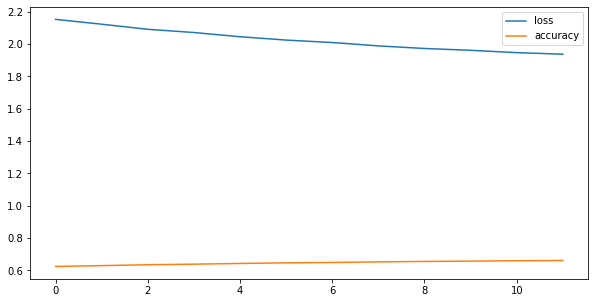

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Autocomplete_data/ukr/Corpus/Model/weights.h5')

In [ ]:
seed_text = 'чіпка'
generated_text = generate_next(seed_text, num_generated=10)
generated_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


'чіпка звиняйте робиш раптово пожар вашої ненавиджу маріам тривоги вартовий помилилися'

In [ ]:
seed_text = 'ого'
generated_text = generate_next(seed_text, num_generated=10)
generated_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


'ого полтавка помремо молоді образився перші вартовий умієш бувайте сестрице масі'

In [ ]:
seed_text = 'куди'
generated_text = generate_next(seed_text, num_generated=10)
generated_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


'куди скочив боїшся ого голий зробили помітили принишк наталю пани-браття робиш'

In [ ]:
#Wall Street Journal